<a href="https://colab.research.google.com/github/superbunny38/SKKUAI/blob/main/model/Alexnet_ImgprocessingCutmix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import Dataset
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import joblib
from tqdm.notebook import tqdm

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from torch.utils.data import Subset
from torchvision import transforms
from torch.optim import lr_scheduler
import os
import re
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import normalize
import PIL.Image as Image
!pip install kornia
import kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.5 MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, Subset
from torch.utils.data.dataloader import *
import os

# Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
!mkdir train_data
#file1 = "/content/drive/MyDrive/train.zip"
#file1 = "/content/drive/MyDrive/ai_competition/train.zip"
file1 = "/content/drive/MyDrive/2022/ai_competition/train.zip"
shutil.unpack_archive(file1, "/content/train_data")

In [ ]:
import os
train_img_root = "/content/train_data/images/"
train_img_names = os.listdir(train_img_root)
len(train_img_names)

10000

In [ ]:
labels = pd.read_csv('/content/train_data/grade_labels.csv')

## Build Dataset

In [ ]:
batch_size = 10
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,

        ])

In [ ]:
df=pd.read_csv('/content/train_data/grade_labels.csv')

labelencoder=preprocessing.LabelEncoder()
df['Grade']=labelencoder.fit(['1++','1+','1','2','3']).transform(df['grade'])

train_len=int(len(df))
class Dataset(Dataset):

    def __init__(self, data, path, transform=None):
        self.data=data # data = csv file
        self.path=path # data directory
        self.transform=transform

    def __getitem__(self, idx):
        file_name = self.data['imname'][idx]
        img = Image.open(self.path+file_name)
        label = self.data['Grade'][idx]
        label = torch.tensor(label, dtype=torch.int64)

        if self.transform:
            data = self.transform(img)

        return data, label
    
    def __len__(self):
        return len(self.data)

whole_dataset = Dataset(df,'/content/train_data/images/',transform=train_transform)

In [ ]:
train_indices = len(whole_dataset)

In [ ]:
trainset, validset = torch.utils.data.random_split(whole_dataset, [9000, 1000])
whole_loader =torch.utils.data.DataLoader(whole_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

# CutMix Algorithm

In [ ]:
def cut(W,H,lam):
        
    ######define the size of box######
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat) 
    ######define the size of box######
    
    #####randomly choose where to cut#####
    cx = np.random.randint(W) # uniform distribution
    cy = np.random.randint(H)
    #####randomly choose where to cut#####

    bbx1 = np.clip(cx - cut_w // 2, 0, W) # Cut, return coordinates of the box 
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [ ]:
images, labels = next(iter(testloader))
cutmix_images = images.clone().detach() # copy Images
cutout_images = images.clone().detach() 
mixup_images = images.clone().detach() 

In [ ]:
rand_index = torch.randperm(images.shape[0]) #Make random indices in a batch to mix between a batch
images_to_mix = images[rand_index]
lam = np.random.beta(1.0, 1.0) # Beta distributtion
bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box

## CUTMIX ##
cutmix_images[:, :, bbx1:bbx2, bby1:bby2] = cutmix_images[rand_index, :, bbx1:bbx2, bby1:bby2]

##* CUTOUT *##
cutout_images[:, :, bbx1:bbx2, bby1:bby2] = 0.

## MIXUP ##
mixup_images = lam * mixup_images + (1 - lam) * mixup_images[rand_index,:,:]

Visualize cutmix method on our data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


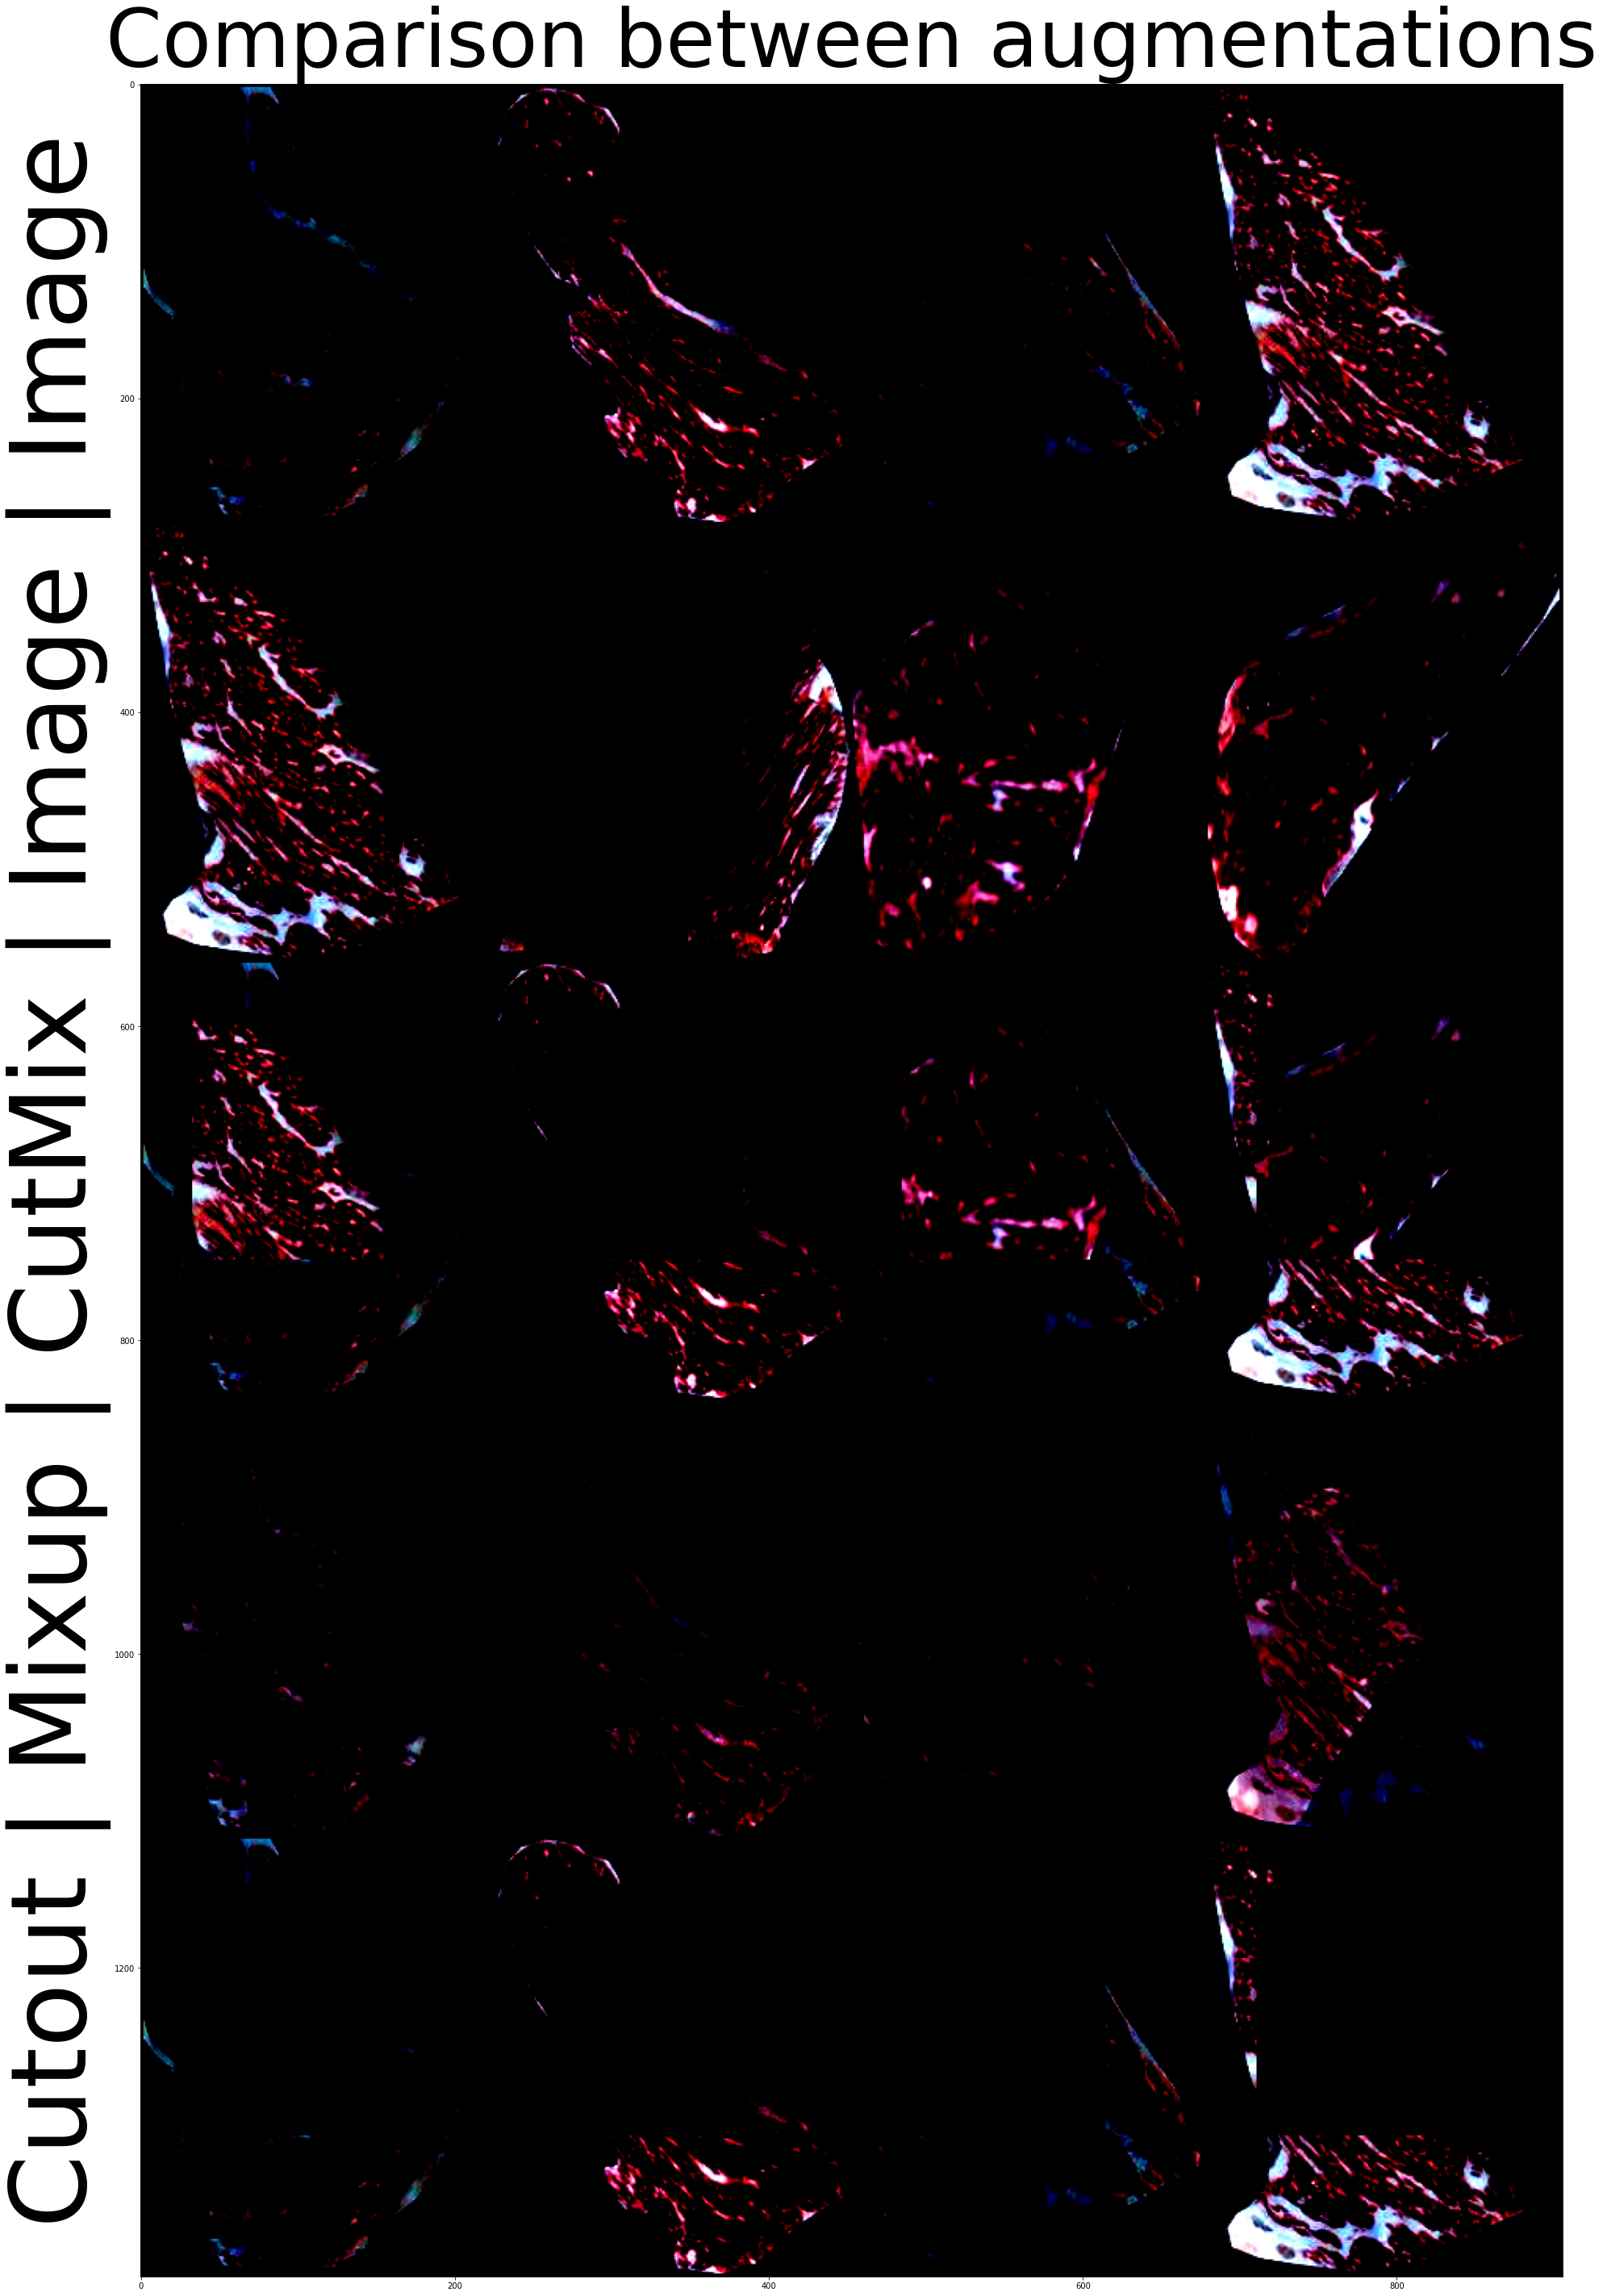

In [ ]:
def show_cutMixed_compare(row1, row2, row3, row4, row5, nums_show): # Let's compare each Algorithm in visual.

    rand_index = torch.randperm(row1.size()[0])[:nums_show]
    to_compare = torch.cat([row1[rand_index,:,:],row2[rand_index,:,:],row3[rand_index,:,:],row4[rand_index,:,:],row5[rand_index,:,:]],dim=0)
    plt.figure(figsize=(50,50))
    grid = torchvision.utils.make_grid(tensor=to_compare, nrow=nums_show)
    plt.ylabel("Cutout | Mixup | CutMix | Image | Image",fontsize=130, rotation = 90)
    plt.title("Comparison between augmentations", fontsize=100)
    plt.imshow(grid.permute(1,2,0))

show_cutMixed_compare(images, images_to_mix, cutmix_images, mixup_images, cutout_images, 4)

# Build Dataset for CutMix

In [ ]:
labels = pd.read_csv('/content/train_data/grade_labels.csv')
labels.head()

,imname,grade
0,cow_1++_4567.jpg,1++
1,cow_2_1390.jpg,2
2,cow_1++_2581.jpg,1++
3,cow_2_1689.jpg,2
4,cow_3_3287.jpg,3


In [ ]:
np.array(labels['imname'])

array(['cow_1++_4567.jpg', 'cow_2_1390.jpg', 'cow_1++_2581.jpg', ...,
       'cow_1+_3478.jpg', 'cow_2_1906.jpg', 'cow_2_5899.jpg'],
      dtype=object)

In [ ]:
def ParseClasses(gt_path):
  df = pd.read_csv(gt_path)
  filenames = np.array(df['imname'])
  classes = np.array(df['grade'])
  return filenames, classes

In [ ]:
df=pd.read_csv('/content/train_data/grade_labels.csv')

labelencoder=preprocessing.LabelEncoder()
df['Grade']=labelencoder.fit(['1++','1+','1','2','3']).transform(df['grade'])

train_len=int(len(df))
class Dataset(Dataset):

    def __init__(self, data, path, transform=None):
        self.data=data # data = csv file
        self.path=path # data directory
        self.transform=transform

    def __getitem__(self, idx):
        file_name = self.data['imname'][idx]
        img = Image.open(self.path+file_name)
        label = self.data['Grade'][idx]
        label = torch.tensor(label, dtype=torch.int64)

        if self.transform:
            data = self.transform(img)

        return data, label
    
    def __len__(self):
        return len(self.data)


train_transform=torchvision.transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

whole_dataset = Dataset(df,'/content/train_data/images/',transform=train_transform)

In [ ]:
def cut(W,H,lam):
        
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [ ]:
from torch.nn import Linear
from torchvision import models

# alexnet model
use_pretrained = False
model = models.alexnet(pretrained=True)

#model.fc = torch.nn.Linear(512, 5) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# model = model.to(device)

cuda


# Model 구조 확인

In [ ]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for n, m in model.named_modules():
     m.auto_name = n
     print(n)


features
features.0
features.1
features.2
features.3
features.4
features.5
features.6
features.7
features.8
features.9
features.10
features.11
features.12
avgpool
classifier
classifier.0
classifier.1
classifier.2
classifier.3
classifier.4
classifier.5
classifier.6


In [ ]:
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=5)

In [ ]:
trainset, validset = torch.utils.data.random_split(whole_dataset, [9000, 1000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                        shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(validset, batch_size=10,
                        shuffle=True, num_workers=0)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import torch
print(torch.cuda.memory_allocated()/1024**2)
import gc
gc.collect()
a = torch.cuda.empty_cache() 
print(torch.cuda.memory_allocated()/1024**2)

0.0
0.0


copy files and move to gdrive

In [ ]:
#cp from to
#/content/0th_checkpoint.pt
!cp /content/*.pt "/content/drive/MyDrive/ai_competition/full_alexnet"

#load model and get validation acc

In [ ]:
#100th epoch model
PATH="/content/trained.pt"
checkpoint = torch.load(PATH) 
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
sum_top1, sum_top5 = 0,0
total=0
correct = 0
for images, labels in testloader :
    images,labels = images.to(device), labels.to(device)
    output = model(images)
    _, predicted = torch.max(output.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
acc = 100 * correct / total
print(f'Val Accuracy: {acc:.2f}')

Val Accuracy: 79.40


# Train w/ Augmentation Data

In [ ]:
# To perform augmentation on GPU, use kornia library.
transform = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomHorizontalFlip(p=0.5),
    kornia.augmentation.RandomVerticalFlip(p = 0.7),
    kornia.augmentation.RandomRotation(90.),# FILL HERE
    kornia.augmentation.ColorJitter(0.4, 0.4, 0.4, 0, p=0.3),# FILL HERE
    kornia.augmentation.RandomGrayscale(p=0.2)# FILL HERE
    #kornia.augmentation.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])# FILL HERE mean, std of CIFAR
)
model.train()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
print(torch.cuda.memory_allocated()/1024**2)
logs = train_model(model, trainloader, testloader, n_iters=30, 
                    learn_rate=0.01, 
                    weight_decay=0, which_method=1)

907.4384765625
GPU loaded?: cuda
30 epochs left


  0%|          | 0/30 [00:00<?, ?it/s]

lr has decayed to 0.00010000000000000003


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

top1 err rate: 25.7
Successfully saved untill 9 step in ./79th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

top1 err rate: 27.0
Successfully saved untill 19 step in ./89th_checkpoint.pt with model, optimizer, and loss.


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

top1 err rate: 26.6
Successfully saved untill 29 step in ./99th_checkpoint.pt with model, optimizer, and loss.
train finished
Successfully saved untill 30 step in ./trained.pt with model, optimizer, and loss.


plot validation error

In [ ]:
#100th epoch model
PATH="/content/trained.pt"
checkpoint = torch.load(PATH) 
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
sum_top1, sum_top5 = 0,0
total=0
correct = 0
for images, labels in testloader :
    images,labels = images.to(device), labels.to(device)
    output = model(images)
    _, predicted = torch.max(output.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
acc = 100 * correct / total
print(f'Val Accuracy: {acc:.2f}')

Val Accuracy: 73.40


In [ ]:
def fit(epoch,model,data_loader,phase='train', mode = "linear", backbone = None, cfg = cfg):
    optimizer = torch.optim.Adam(model.parameters(), lr = cfg.train.lr, weight_decay = cfg.train.weight_decay)
    if phase == 'train':
        model.train()
    if phase == 'test':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
      
        data,target = data.cuda(),target.cuda()
        
        if phase == 'train':
          optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.cross_entropy(output,target)
        running_loss +=  F.cross_entropy(output,target,size_average=False).data#[0]
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'train':
          loss.backward()
          optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    return model, loss, accuracy

In [ ]:
model, test_loss, test_acc = fit(1, model, test_loader, phase = "test", mode = 'finetune')
print(f"test loss: {test_loss}, test_acc: {test_acc}")

test loss: 0.1552583873271942, test_acc: 98.19999694824219


In [ ]:
model, test_loss, test_acc = fit(1, model, train_loader, phase = "test", mode = 'finetune')
print(f"test loss: {test_loss}, test_acc: {test_acc}")

test loss: 0.15599627792835236, test_acc: 97.9111099243164


In [ ]:
pd.read_csv('/content/sample_submission (2).csv').head()

,id,grade
0,sVLxe6JXJJ.jpg,1++
1,dOYMQKHfpS.jpg,1++
2,gb9WAHG1kq.jpg,1++
3,fkh92IiU7R.jpg,1++
4,YPb2itGH9U.jpg,1++
